
# The Penny Analyst (Costs only a cent to run!)

**Run whole notebook once. Then call invest(ticker, client). Initial set-up time should be less than 5mins. Response time per call of invest should be less than a minute for client=False, Growth, Income and about 1.5mins for ESG. Reccomendations are non-deterministic, variation is expected. API key is billing limited, will be good for at several dozen calls, 1 cent per non-ESG call, 2-3 per ESG call.**

This file contains stock recommendation analyst that will take a provided ticker and an optional client type (i.e., esg, income, and growth) and offer a narrative recommendation on whether you should consider investing in it with the specific goal of beating the SP500 over 10 years (measured in CAGR). The architecture of system has two parts. First is modelling. The system has access to it a Generalised Additive Model (*gam* [variables/objects in italics]) that is trained on financial data on all SP500 companies with the target variable of whether they beat the index in 10 year trailing CAGR. The model is trained each time the whole notebook is run, pulling the most recent 10 years of data. The model only considers the following financial metrics (which are a subset of those pulled via the financial_metrics method provided by yquery:

recommendationMean, numberOfAnalystOpinions, totalCashPerShare, quickRatio, currentRatio, debtToEquity, revenuePerShare, returnOnAssets, returnOnEquity, earningsGrowth, revenueGrowth, grossMargins, ebitdaMargins, operatingMargins, profitMargins, targetHighPrice_pct_diff, targetLowPrice_pct_diff, targetMeanPrice_pct_diff, targetMedianPrice_pct_diff

These were chosen because they are generally agnostic to company size. The last three reflect the percentage difference between the current stock price and the low, mean, and median of the target prices (the raw data is just absolute prices which would not be comparable).

The product of the modelling stage is an image of partial dependency plots (*plot_partial_dependence*) which show the marginal effect of  each variable on whether the stock will beat the SP500 (blue line; red are confidence intervals) holding all other variables at their average. A lower recommendation mean for example leads to a worser outlook. The effect need not be linear, for example there is a goldilocks zone for returnOnEquity (around the middle of the graph) which translates into the best outlook (this makes sense given a ROE might not always be good, it can also mean excess risk). 

The metrics of the user selected company are plotted on the graphs as purple dots. This final graph sheet is printed for the use to see and  is passed onto the next part of the system: the analyst (*analysis*).

The analyst takes in the graph sheet and the model prediction and analyses it to come up with a narrative recommendation. This is done via querying the OpenAI API with an engineered prompt that instructs GPT-4-Vision to make a narrative recommendation based on the model prediction and the graph sheet. The narrative is a typically 400-600 words long.

The user also has the option to specify a client type: esg, growth or income. This modifies the analyst prompt to take into account that preference. For all types, the analyst is instructed to consider both the model's prediction (i.e., whether the stock is likely to outperform) and the goodness of fit of the stock for the particular portfolio type. This means in principle the analyst can decline to recommend include a stock that has all the classic features of say a growth stock but is unlikely to outperform the SP500. 

For in particular ESG, there is a secondary analyst (*esg_analyst*) that interprets the given companies ESG score (found by the *esg_scores* method) and passes a summary to the main analyst. The main analyst is instructed to consider this summary in their recommendation assessment. The ESG analyst's opinion is appended to the end of the recommendation for reference. Where there is no ESG data the analyst will mention it.

The analyst is instructed to end their narrative with either buy, hold or sell, which is extracted and used as the return for *invest*. In the case that the analyst fails to do so, *model_prediction* is used, where True maps to buy, and False to sell.

### Run if needed

In [ ]:
%pip install pandas
%pip install yahooquery
%pip install numpy
%pip install pygam
%pip install matplotlib
%pip install requests
%pip install openai

In [5]:
import pandas as pd
from yahooquery import *
import numpy as np
import warnings
from pygam import LogisticGAM, s, f
from matplotlib import pyplot as plt
import base64
import requests
api_key = ""

warnings.filterwarnings(action='ignore', category=FutureWarning)


In [6]:
sp500_tickers = ('^GSPC', 'MSFT','AAPL','NVDA','AMZN','GOOGL','GOOG','META','BRK.B','LLY','AVGO','V','TSLA','JPM','WMT','MA','UNH','XOM','JNJ','PG','HD','COST','AMD','ABBV','MRK','ORCL','CRM','BAC','CVX','NFLX','KO','ADBE','ACN','TMO','PEP','LIN','MCD','ABT','WFC','DIS','TMUS','CSCO','INTC','QCOM','DHR','INTU','IBM','AMAT','GE','VZ','CAT','CMCSA','UBER','AXP','TXN','UNP','PFE','NOW','BX','AMGN','NKE','PM','MS','LOW','ISRG','SYK','SPGI','COP','HON','UPS','LRCX','GS','SCHW','BLK','PLD','T','BA','RTX','ETN','ELV','BKNG','PGR','NEE','MDT','TJX','C','BMY','REGN','VRTX','MU','LMT','ABNB','SBUX','DE','CB','CI','ADP','MMC','BSX','KLAC','MDLZ','AMT','ADI','CVS','GILD','PANW','ANET','FI','SNPS','EQIX','HCA','SHW','CDNS','ZTS','WM','ICE','TGT','CME','ITW','GD','SO','CSX','CMG','MO','SLB','DUK','MCO','CL','MAR','NOC','MCK','PH','BDX','EOG','USB','APH','TT','TDG','NXPI','ORLY','ECL','CTAS','MPC','PYPL','AON','PSX','EMR','FDX','MNST','PCAR','PNC','RSG','ROP','NSC','SPG','CEG','LULU','PXD','MSI','FCX','FTNT','APD','AJG','AZO','OXY','ADSK','EW','CARR','CPRT','WELL','EL','COF','DXCM','MET','HLT','MMM','AIG','TRV','DHI','PSA','MCHP','ROST','TFC','F','CCI','GWW','VLO','DLR','AFL','ODFL','GM','IDXX','IQV','URI','STZ','NUE','OKE','SRE','O','LEN','WMB','AEP','HES','TEL','MSCI','PAYX','PCG','KHC','A','GEHC','FAST','BK','KMB','AMP','AME','CNC','ALL','JCI','LHX','HUM','DOW','KDP','FIS','CHTR','SYY','KMI','D','YUM','PRU','HSY','CMI','OTIS','KR','NEM','COR','CTSH','LVS','CTVA','MLM','KVUE','MRNA','GIS','IR','EXC','IT','EA','CSGP','ON','VMC','PWR','MPWR','DG','VRSK','ROK','NDAQ','ACGL','CDW','GPN','PPG','EFX','RCL','DLTR','LYB','PEG','FANG','FICO','BIIB','EXR','HAL','ED','BKR','XYL','VICI','DFS','FTV','HPQ','DD','ANSS','HIG','ADM','DVN','MTD','HWM','WTW','CBRE','RMD','GLW','KEYS','TSCO','DAL','CAH','XEL','GRMN','ULTA','EIX','ZBH','EBAY','TROW','AVB','BF.B','WST','WEC','RJF','WAB','WY','CHD','NVR','FITB','TTWO','BLDR','BRO','BR','DOV','EQR','AXON','PHM','MTB','IRM','HPE','SBAC','AWK','TRGP','DTE','LYV','ALGN','MOH','STE','STT','PTC','ETR','ARE','BAX','APTV','WRB','ROL','NTAP','FE','ILMN','INVH','WDC','HUBB','STLD','DRI','CCL','GPC','ES','FLT','WAT','JBHT','LUV','WBD','COO','BALL','TDY','CBOE','PPL','CTRA','IFF','HBAN','JBL','AEE','STX','VRSN','TSN','PFG','VLTO','HRL','CLX','J','CINF','K','LH','MKC','EXPE','WBA','TYL','OMC','IEX','EPAM','CNP','RF','CMS','FDS','HOLX','LDOS','TXT','EXPD','ATO','VTR','AVY','FSLR','ENPH','SYF','BBY','MAS','L','SWKS','AKAM','NTRS','EQT','CE','PKG','TER','ESS','EG','MAA','POOL','DPZ','CFG','CF','TRMB','NDSN','SNA','NWS','NWSA','HST','LW','ZBRA','BEN','VTRS','UAL','ALB','DGX','KEY','SWK','MRO','LKQ','GEN','MGM','CRL','CAG','BG','TAP','INCY','AMCR','RVTY','UDR','PNR','KIM','CPB','FOXA','FOX','NRG','SJM','KMX','JKHY','LNT','AOS','IP','JNPR','IPG','NI','GL','UHS','TECH','EVRG','HII','WRK','PODD','DVA','AES','RL','REG','ALLE','QRVO','FFIV','WYNN','TPR','TFX','CPT','CTLT','EMN','BBWI','MOS','DAY','PAYC','BXP','AAL','HSIC','BIO','DOC','AIZ','APA','MTCH','CZR','NCLH','FRT','CHRW','RHI','ETSY','PNW','MKTX','FMC','MHK','BWA','PARA','HAS','XRAY','IVZ','CMA','GNRC','ZION','VFC','WHR')

In [7]:
sp500_10yr_prices = Ticker(list(sp500_tickers)).history(period='10y')

In [8]:
def calculate_cagr(df):
    result = pd.DataFrame(columns=["CAGR"])
    for i in sp500_tickers:
        try:
            df_i = df.loc[i]
            beginning_value = df_i['close'].iloc[0]
            ending_value = df_i['close'].iloc[-1]

            num_years = 10

            cagr = (ending_value / beginning_value) ** (1 / num_years) - 1
            cagr = cagr * 100  # Convert to percentage

            result.loc[i] = [cagr]
        except (IndexError, KeyError):
            result.loc[i] = [None]
    return result


In [9]:
sp500_10yr_cagr = calculate_cagr(sp500_10yr_prices)

In [10]:
sp500_financial_data = Ticker(list(sp500_tickers)).financial_data

In [11]:
sp500_financial_data_pd = pd.DataFrame(sp500_financial_data).transpose().replace()

sp500_financial_data_pd.replace(to_replace=r'^\D+$', value=None, regex=True, inplace=True)

sp500_financial_data_pd

,maxAge,currentPrice,targetHighPrice,targetLowPrice,targetMeanPrice,targetMedianPrice,recommendationMean,recommendationKey,numberOfAnalystOpinions,totalCash,...,returnOnEquity,freeCashflow,operatingCashflow,earningsGrowth,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins,profitMargins,financialCurrency
^GSPC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
MSFT,86400.0,419.0393,515.35,279.32,433.15,435.24,1.7,None,48.0,8.098200e+10,...,0.39174,5.868100e+10,1.026470e+11,0.332,0.176,0.69815,0.52037,0.43586,0.36269,None
AAPL,86400.0,175.3400,234.25,148.05,187.37,187.40,2.2,None,38.0,7.310000e+10,...,1.54269,8.656313e+10,1.164330e+11,0.160,0.021,0.45027,0.33733,0.33764,0.26163,None
NVDA,86400.0,878.7207,2588.11,448.26,936.97,937.00,1.7,None,46.0,2.598400e+10,...,0.91458,1.986688e+10,2.809000e+10,7.613,2.653,0.72718,0.56597,0.61593,0.48849,None
AMZN,86400.0,185.5000,223.01,148.05,196.39,196.77,1.7,None,51.0,8.678000e+10,...,0.17490,4.547575e+10,8.494600e+10,50.693,0.139,0.46982,0.14878,0.07525,0.05293,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMA,86400.0,50.5000,68.00,52.00,59.08,59.00,2.6,None,20.0,1.006700e+10,...,0.15207,7.055500e+08,1.251000e+09,-0.924,-0.220,0.00000,0.00000,0.27273,0.25150,None
GNRC,86400.0,128.6500,175.00,78.00,138.41,143.00,2.1,None,22.0,2.009940e+08,...,0.09201,3.360650e+08,5.216700e+08,0.894,0.014,0.33943,0.13754,0.14236,0.05335,None
ZION,86400.0,40.3610,51.00,39.00,45.40,45.50,3.0,None,20.0,3.609000e+09,...,0.12850,3.360650e+08,8.850000e+08,-0.575,-0.119,0.00000,0.00000,0.35431,0.22796,None
VFC,86400.0,12.2650,25.00,13.00,16.99,16.00,2.8,None,19.0,9.897430e+08,...,-0.28200,1.006068e+09,1.283424e+09,-0.575,-0.162,0.52269,0.09874,0.09316,-0.07074,None


In [12]:
sp500_financial_data_pd.columns

Index(['maxAge', 'currentPrice', 'targetHighPrice', 'targetLowPrice',
       'targetMeanPrice', 'targetMedianPrice', 'recommendationMean',
       'recommendationKey', 'numberOfAnalystOpinions', 'totalCash',
       'totalCashPerShare', 'ebitda', 'totalDebt', 'quickRatio',
       'currentRatio', 'totalRevenue', 'debtToEquity', 'revenuePerShare',
       'returnOnAssets', 'returnOnEquity', 'freeCashflow', 'operatingCashflow',
       'earningsGrowth', 'revenueGrowth', 'grossMargins', 'ebitdaMargins',
       'operatingMargins', 'profitMargins', 'financialCurrency'],
      dtype='object')

In [13]:
fin_data_normalised = sp500_financial_data_pd.copy()
fin_data_normalised['targetHighPrice_pct_diff'] = (fin_data_normalised['targetHighPrice'] - fin_data_normalised['currentPrice']) / fin_data_normalised['currentPrice'] 
fin_data_normalised['targetLowPrice_pct_diff'] = (fin_data_normalised['targetLowPrice'] - fin_data_normalised['currentPrice']) / fin_data_normalised['currentPrice'] 
fin_data_normalised['targetMeanPrice_pct_diff'] = (fin_data_normalised['targetMeanPrice'] - fin_data_normalised['currentPrice']) / fin_data_normalised['currentPrice'] 
fin_data_normalised['targetMedianPrice_pct_diff'] = (fin_data_normalised['targetMedianPrice'] - fin_data_normalised['currentPrice']) / fin_data_normalised['currentPrice'] 
fin_data_normalised.head()

,maxAge,currentPrice,targetHighPrice,targetLowPrice,targetMeanPrice,targetMedianPrice,recommendationMean,recommendationKey,numberOfAnalystOpinions,totalCash,...,revenueGrowth,grossMargins,ebitdaMargins,operatingMargins,profitMargins,financialCurrency,targetHighPrice_pct_diff,targetLowPrice_pct_diff,targetMeanPrice_pct_diff,targetMedianPrice_pct_diff
^GSPC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
MSFT,86400.0,419.0393,515.35,279.32,433.15,435.24,1.7,None,48.0,8.098200e+10,...,0.176,0.69815,0.52037,0.43586,0.36269,None,0.229837,-0.333428,0.033674,0.038662
AAPL,86400.0,175.3400,234.25,148.05,187.37,187.40,2.2,None,38.0,7.310000e+10,...,0.021,0.45027,0.33733,0.33764,0.26163,None,0.335976,-0.155640,0.068610,0.068781
NVDA,86400.0,878.7207,2588.11,448.26,936.97,937.00,1.7,None,46.0,2.598400e+10,...,2.653,0.72718,0.56597,0.61593,0.48849,None,1.945316,-0.489872,0.066289,0.066323
AMZN,86400.0,185.5000,223.01,148.05,196.39,196.77,1.7,None,51.0,8.678000e+10,...,0.139,0.46982,0.14878,0.07525,0.05293,None,0.202210,-0.201887,0.058706,0.060755


In [14]:
# Loaded variable 'fin_data_normalised' from kernel state

# Drop columns: 'targetMeanPrice', 'targetMedianPrice'
fin_data_normalised = fin_data_normalised.drop(columns=['targetMeanPrice', 'targetMedianPrice'])

# Drop columns: 'targetLowPrice', 'maxAge' and 2 other columns
fin_data_normalised = fin_data_normalised.drop(columns=['targetLowPrice', 'maxAge', 'currentPrice', 'targetHighPrice'])

# Drop column: 'totalCash'
fin_data_normalised = fin_data_normalised.drop(columns=['totalCash'])

# Drop columns: 'ebitda', 'totalDebt'
fin_data_normalised = fin_data_normalised.drop(columns=['ebitda', 'totalDebt'])

# Drop columns: 'freeCashflow', 'operatingCashflow'
fin_data_normalised = fin_data_normalised.drop(columns=['freeCashflow', 'operatingCashflow', 'totalRevenue'])

# Drop column: 'financialCurrency'
fin_data_normalised = fin_data_normalised.drop(columns=['financialCurrency'])

# Drop column: 'recommendationKey'
fin_data_normalised = fin_data_normalised.drop(columns=['recommendationKey'])

In [15]:
fin_data_normalised.columns

Index(['recommendationMean', 'numberOfAnalystOpinions', 'totalCashPerShare',
       'quickRatio', 'currentRatio', 'debtToEquity', 'revenuePerShare',
       'returnOnAssets', 'returnOnEquity', 'earningsGrowth', 'revenueGrowth',
       'grossMargins', 'ebitdaMargins', 'operatingMargins', 'profitMargins',
       'targetHighPrice_pct_diff', 'targetLowPrice_pct_diff',
       'targetMeanPrice_pct_diff', 'targetMedianPrice_pct_diff'],
      dtype='object')

In [16]:
for i in fin_data_normalised.columns:
    print(i+", ")

recommendationMean, 
numberOfAnalystOpinions, 
totalCashPerShare, 
quickRatio, 
currentRatio, 
debtToEquity, 
revenuePerShare, 
returnOnAssets, 
returnOnEquity, 
earningsGrowth, 
revenueGrowth, 
grossMargins, 
ebitdaMargins, 
operatingMargins, 
profitMargins, 
targetHighPrice_pct_diff, 
targetLowPrice_pct_diff, 
targetMeanPrice_pct_diff, 
targetMedianPrice_pct_diff, 


In [17]:
sp500_financial_data_cagr_pd = pd.concat([fin_data_normalised, sp500_10yr_cagr], axis=1)
sp500_financial_data_cagr_pd_save = sp500_financial_data_cagr_pd.copy()

In [18]:
sp500_financial_data_cagr_pd['better_than_spy'] = sp500_financial_data_cagr_pd['CAGR'] > sp500_financial_data_cagr_pd['CAGR'].iloc[0]


In [19]:
sp500_financial_data_cagr_pd = sp500_financial_data_cagr_pd.drop(sp500_financial_data_cagr_pd.index[0])

sp500_financial_data_cagr_pd = sp500_financial_data_cagr_pd.drop("CAGR", axis=1)

sp500_financial_data_cagr_pd = sp500_financial_data_cagr_pd.dropna()

In [20]:
X = sp500_financial_data_cagr_pd.drop('better_than_spy', axis=1).values
y = sp500_financial_data_cagr_pd['better_than_spy'].values.astype(int)  # Convert boolean to integer (True=1, False=0)

gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18), lam = 1)
gam.fit(X, y) 


c:\Users\seanm\OneDrive - Ngee Ann Polytechnic\YNC\Y3S2\CS 458\HW2\.venv\lib\site-packages\pygam\links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
c:\Users\seanm\OneDrive - Ngee Ann Polytechnic\YNC\Y3S2\CS 458\HW2\.venv\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
c:\Users\seanm\OneDrive - Ngee Ann Polytechnic\YNC\Y3S2\CS 458\HW2\.venv\lib\site-packages\pygam\pygam.py:627: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
c:\Users\seanm\OneDrive - Ngee Ann Polytechnic\YNC\Y3S2\CS 458\HW2\.venv\lib\site-packages\pygam\links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
c:\Users\seanm\OneDrive - Ngee Ann Polytechnic\YNC\Y3S2\CS 458\HW2\.venv\lib\site-packages\pygam\links.py:134: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / 

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + intercept,
   tol=0.0001, verbose=False)

In [21]:
# CITATION: Boilderplate is from the PYGAM documentation, modified to add purple dots to where's user's stocks lie.

def plot_partial_dependence(gam, combined, tkt):
    # Assuming `gam` is your fitted GAM model, and `fin_data_normalised.columns` contains your feature names
    titles = combined.drop('better_than_spy', axis=1).columns

    # Create a 3x7 grid of subplots
    fig, axs = plt.subplots(3, 7, figsize=(20, 10))  # Adjust figsize as needed

    # Flatten the axs array for easier iteration
    axs_flat = axs.flatten()

    for i, ax in enumerate(axs_flat):
        if i < len(titles):  # Check if the current index is less than the number of features
            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

            # Plot partial dependence
            ax.plot(XX[:, i], pdep)
            ax.plot(XX[:, i], confi[:,0], c='r', ls='--')
            ax.plot(XX[:, i], confi[:,1], c='r', ls='--')

            # Add a dot for the values in combined.loc["MSFT"].drop('better_than_spy').values.reshape(1, -1)
            dot_x = combined.loc[tkt].drop('better_than_spy').values.reshape(1, -1)[0][i]
            dot_y = gam.predict(combined.loc[tkt].drop('better_than_spy').values.reshape(1, -1))

            # Plot purple circles
            ax.plot(dot_x, dot_y, color='purple', marker='o')

            # Additional customization
            if i == 0:
                ax.set_ylim(-30, 30)
            ax.set_title(titles[i])
        else:
            # Hide the axes if there are no more features to plot
            ax.set_visible(False)

    # Add a title to the plot
    plt.suptitle(f"{tkt} performance relative to SP500 universe", fontsize=30)

    plt.tight_layout()
    plt.savefig('partial_dependence_plot.png')  # Save the plot as an image file
    plt.show()

In [22]:
gam.accuracy(X, y)

0.8363273453093812

In [23]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     61.7675
Link Function:                        LogitLink Log Likelihood:                                  -182.1751
Number of Samples:                          501 AIC:                                              487.8851
                                                AICc:                                             506.1936
                                                UBRE:                                               3.0725
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4637
Feature Function                  Lam

C:\Users\seanm\AppData\Local\Temp\ipykernel_45452\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [24]:
sp500_esg = Ticker(list(sp500_tickers)).esg_scores
sp500_esg_pd = pd.DataFrame(sp500_esg).transpose()

def get_row_by_ticker(ticker, data):
    return data.loc[ticker]

get_row_by_ticker("WMT", sp500_esg_pd)

maxAge                                                                           86400
totalEsg                                                                         25.26
environmentScore                                                                  5.86
socialScore                                                                      12.36
governanceScore                                                                   7.05
ratingYear                                                                        2023
ratingMonth                                                                          9
highestControversy                                                                 3.0
peerCount                                                                           33
esgPerformance                                                                AVG_PERF
peerGroup                                                               Food Retailers
relatedControversy                   [Emplo

In [25]:
def esg_analyst(ticker, data):
  esg_data = get_row_by_ticker(ticker, data)
  headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
  }

  payload = {
    "model": "gpt-4-1106-preview",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f'''
              You're an esg analyst and you're given the esg scores a company below. Look at it and summarise whether you fell the company is a good investment from an esg perspective.
              Your result will be passed to another analyst who will combine your opinion with their opinion based on the company's financial metrics it to make a recommendation. 

              The data is here:
              {esg_data}

              The peer scores for each category and overall are in the peerEsgScorePerformance, peerGovernancePerformance, peerSocialPerformance, 
              peerEnvironmentPerformance, peerHighestControversyPerformance variables. Use those to help understand whether the companies scores are good or bad.
              '''
          }
        ]
      }
    ],
    "max_tokens": 4000
  }
  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
  return response.json().get('choices')[0].get('message').get('content')

In [26]:
# esg_analyst("WMT", sp500_esg_pd)

In [27]:
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

In [28]:
import re
def analysis(ticker, model, data, client=False):
  plot_partial_dependence(model, data, ticker)
  model_prediction = model.predict(data.loc[ticker].drop('better_than_spy').values.reshape(1, -1))
  stocksheet = sp500_financial_data_cagr_pd.loc['T'][:-1]
  
  # Path to your image
  image_path = "partial_dependence_plot.png"

  # Getting the base64 string
  base64_image = encode_image(image_path)

  headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
  }

  if client == False:
    prompt = f'''
              You're given the results of a logisticsgam that predicts if a stock has a better 10 year cagr than the sp500. 
              The photo shows the partial dependence plots. The purple dots are where the stock lies on the plot. 
              The raw values for the stock are: {stocksheet}
              The model predicts {model_prediction}.
              Use the partial dependence graphs to explain why the model returned {model_prediction} with the company values provided. 
              Respond as if you were a stock analyst relying on this data to give a recommendation.
              Pitch the stock as if you ran the model and did the research yourself.
              Make sure your explanation makes sense to a non-technical audience.
              At end give a summary clearly stating your reccomendation.

              Lastly you must end of your response with either: buy, hold or sell, depending on your analysis before. Single word only.
              '''
  if client == "esg":
    esg_opinion = esg_analyst(ticker, sp500_esg_pd)
    prompt= f'''
              Financial Analysis:
              You're given the results of a logisticsgam that predicts if a stock has a better 10 year cagr than the sp500. 
              The photo shows the partial dependence plots. The purple dots are where the stock lies on the plot. 
              The raw values for the stock are: {stocksheet}
              The model predicts {model_prediction}.
              Use the partial dependence graphs to explain why the model returned {model_prediction} with the company values provided. You can mention what
              value the company got where it lies on the curve and whether that is a good or bad thing.
              Respond as if you were a stock analyst relying on this data to give a recommendation.
              Pitch the stock as if you ran the model and did the research yourself.
              Make sure your explanation makes sense to a non-technical audience. 
              At end give a summary clearly stating your reccomendation.
              
              ESG Consideration: 
              Then consider the esg analysis given to you by the esg analyst below and come to an overall conclusion as to whether this 
              stock is a good investment from an esg perspective while still considering the financial metrics.
              Your reccomdentations can differ between the two but make sure to justify your decision. 

              The esg opinion is here {esg_opinion}

              Lastly you must end of your response with either: buy, hold or sell, depending on your analysis before. Single word only.
              '''
    
  if client == "income":
    prompt= f'''
              Financial Analysis:
              You're given the results of a logisticsgam that predicts if a stock has a better 10 year cagr than the sp500. 
              The photo shows the partial dependence plots. The purple dots are where the stock lies on the plot. 
              The raw values for the stock are: {stocksheet}
              The model predicts {model_prediction}.
              Use the partial dependence graphs to explain why the model returned {model_prediction} with the company values provided.You can mention what
              value the company got where it lies on the curve and whether that is a good or bad thing.
              Remember focus on what these values mean for why the reader should believe the stock will do well or not.
              Respond as if you were a stock analyst relying on this data to give a recommendation. 
              Specifically consider wether this stock should be part of an income portfolio both in terms of whether
              it's metrics traditional income measures are high and the quality of the stock based on the model.
              It is okay not to reccomend the stock even if it has high income-related measures but the model disagrees that it 
              can perform well.
              Pitch the stock as if you ran the model and did the research yourself.
              Make sure your explanation makes sense to a non-technical audience.
              At end give a summary clearly stating your reccomendation.

              Lastly you must end of your response with either: buy, hold or sell, depending on your analysis before. Single word only.
              '''
  if client == "growth":
    prompt = f'''
            You're given the results of a logisticsgam that predicts if a stock has a better 10 year cagr than the sp500. 
            The photo shows the partial dependence plots. The purple dots are where the stock lies on the plot. 
            The raw values for the stock are: {stocksheet}
            The model predicts {model_prediction}.
            Use the partial dependence graphs to explain why the model returned {model_prediction} with the company values provided. You can mention what
            value the company got where it lies on the curve and whether that is a good or bad thing.
            Respond as if you were a stock analyst relying on this data to give a recommendation.
            Pitch the stock as if you ran the model and did the research yourself.
            Make sure your explanation makes sense to a non-technical audience.

            Then consider whether this stock should be part of an growth portfolio both in terms of whether
            it's metrics traditional growth measures are high and the quality of the stock based on the model.
            It is okay not to reccomend the stock even if it has high growth-related measures but the model disagrees that it 
            can perform well.
            At end give a summary clearly stating your reccomendation.

            Lastly you must end of your response with either: buy, hold or sell, depending on your analysis before. Single word only.
            '''

  payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": prompt
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }
        ]
      }
    ],
    "max_tokens": 4000
  }
  response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
  if client == "esg":
    reply = f"{response.json().get('choices')[0].get('message').get('content')} \n\n\nBelow is the ESG Analyst Opinion that was used in the decision:\n{esg_opinion}"
  else:
    reply = f"{response.json().get('choices')[0].get('message').get('content')}"
  
# Search for "buy", "hold", or "sell" in the reply
  # Store the matching result
  match = re.search(r"(buy|hold|sell)(?=\W|$)", reply, re.IGNORECASE)

  if match is not None:
    recommendation = match.group()
  else:
    if model_prediction:
      recommendation = "buy"
    else:
      recommendation = "sell"

  print(recommendation+"\n")

  print(reply)

  return recommendation

In [29]:
def invest(ticker, client=False):
    return analysis(ticker, gam, sp500_financial_data_cagr_pd, client=client)

## Apple, client = False

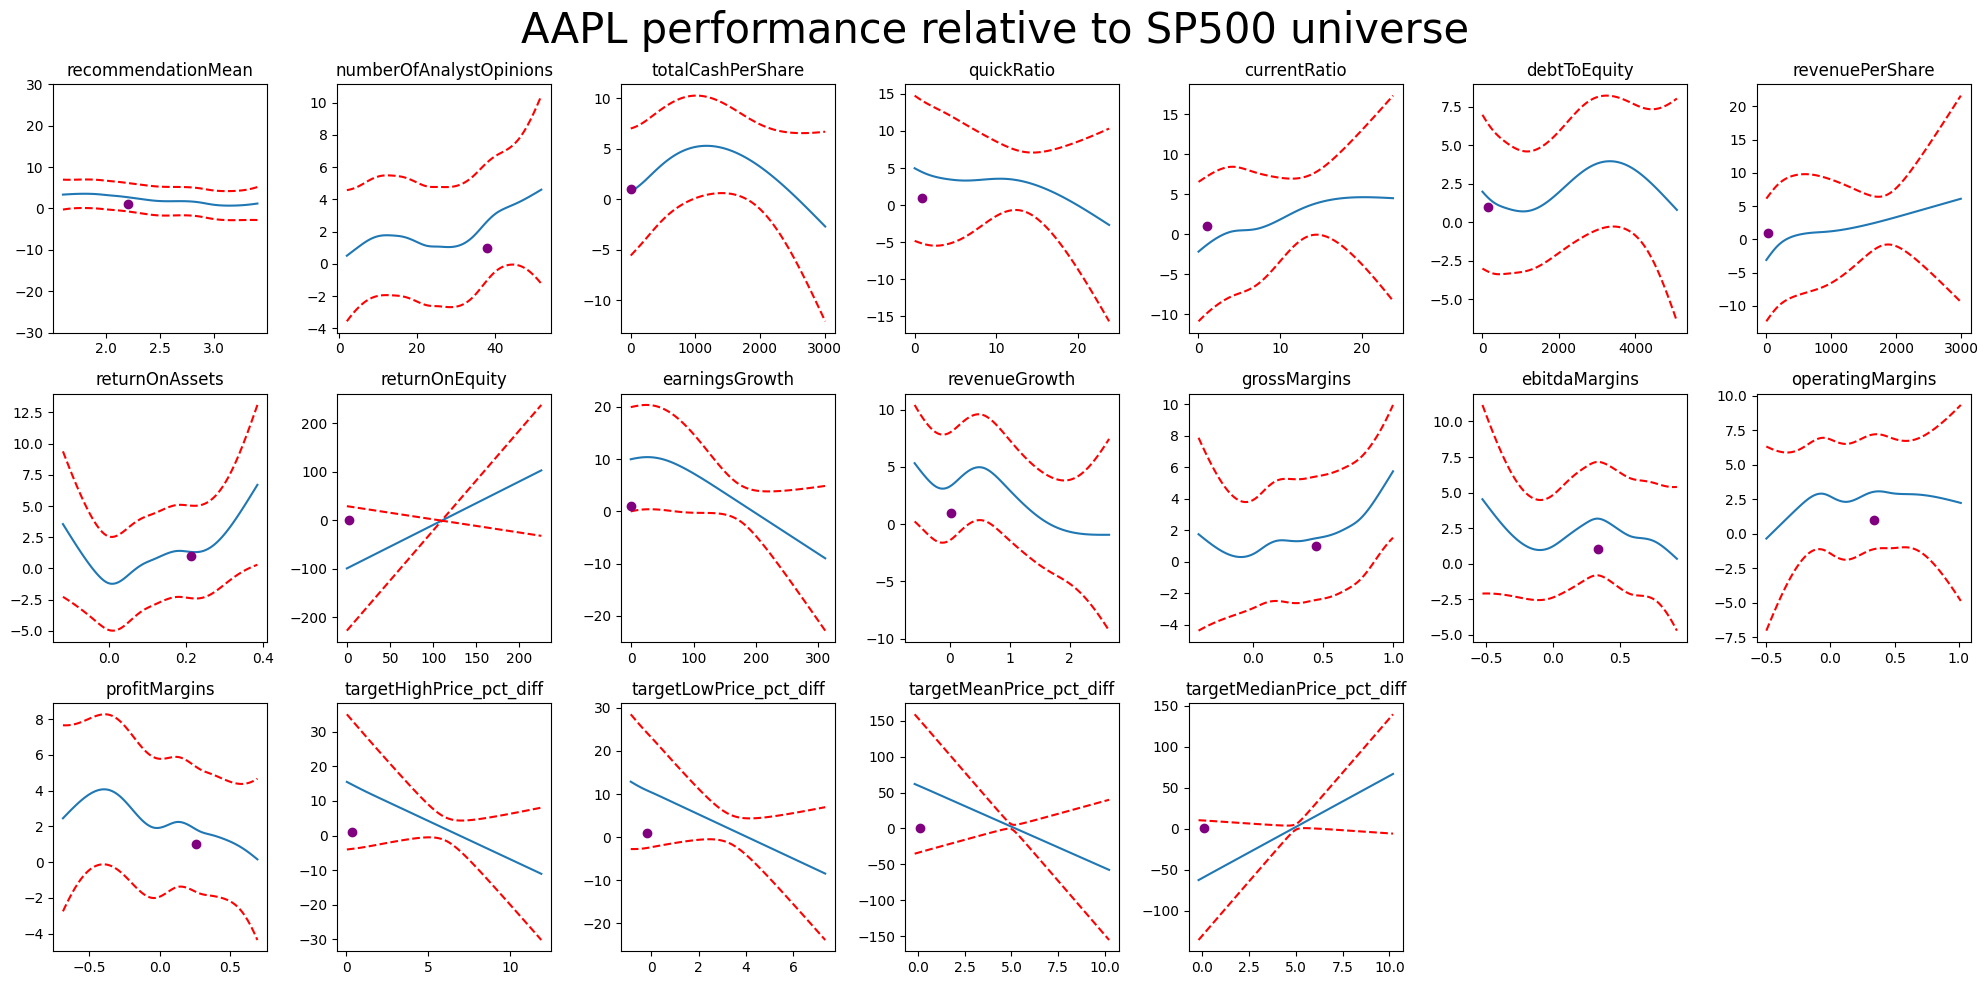

buy

Let's walk through the partial dependence plots and how they relate to the stock's predicted performance relative to the S&P 500 over a 10-year period, taking into account the company's raw values.

1. **Recommendation Mean (2.4):** The plot shows that a recommendation mean around 2.4, which is closer to a "buy" recommendation, generally correlates with better performance than the S&P 500. The position of the stock on this plot is in a favorable range.

2. **Number of Analyst Opinions (23.0):** With a higher number of analyst opinions, the stock tends to perform better. In this case, the stock has a substantial number of opinions, which the model interprets as a positive signal.

3. **Total Cash Per Share (0.951):** While not at an extreme value, the company's cash position per share is in a neutral range, which doesn't seem to be a strong indicator of outperformance, according to the plot.

4. **Quick Ratio (0.429):** The company's quick ratio is lower than ideal, indicating liqu

'buy'

In [30]:
invest("AAPL", client=False)

## Walmart, client=Income

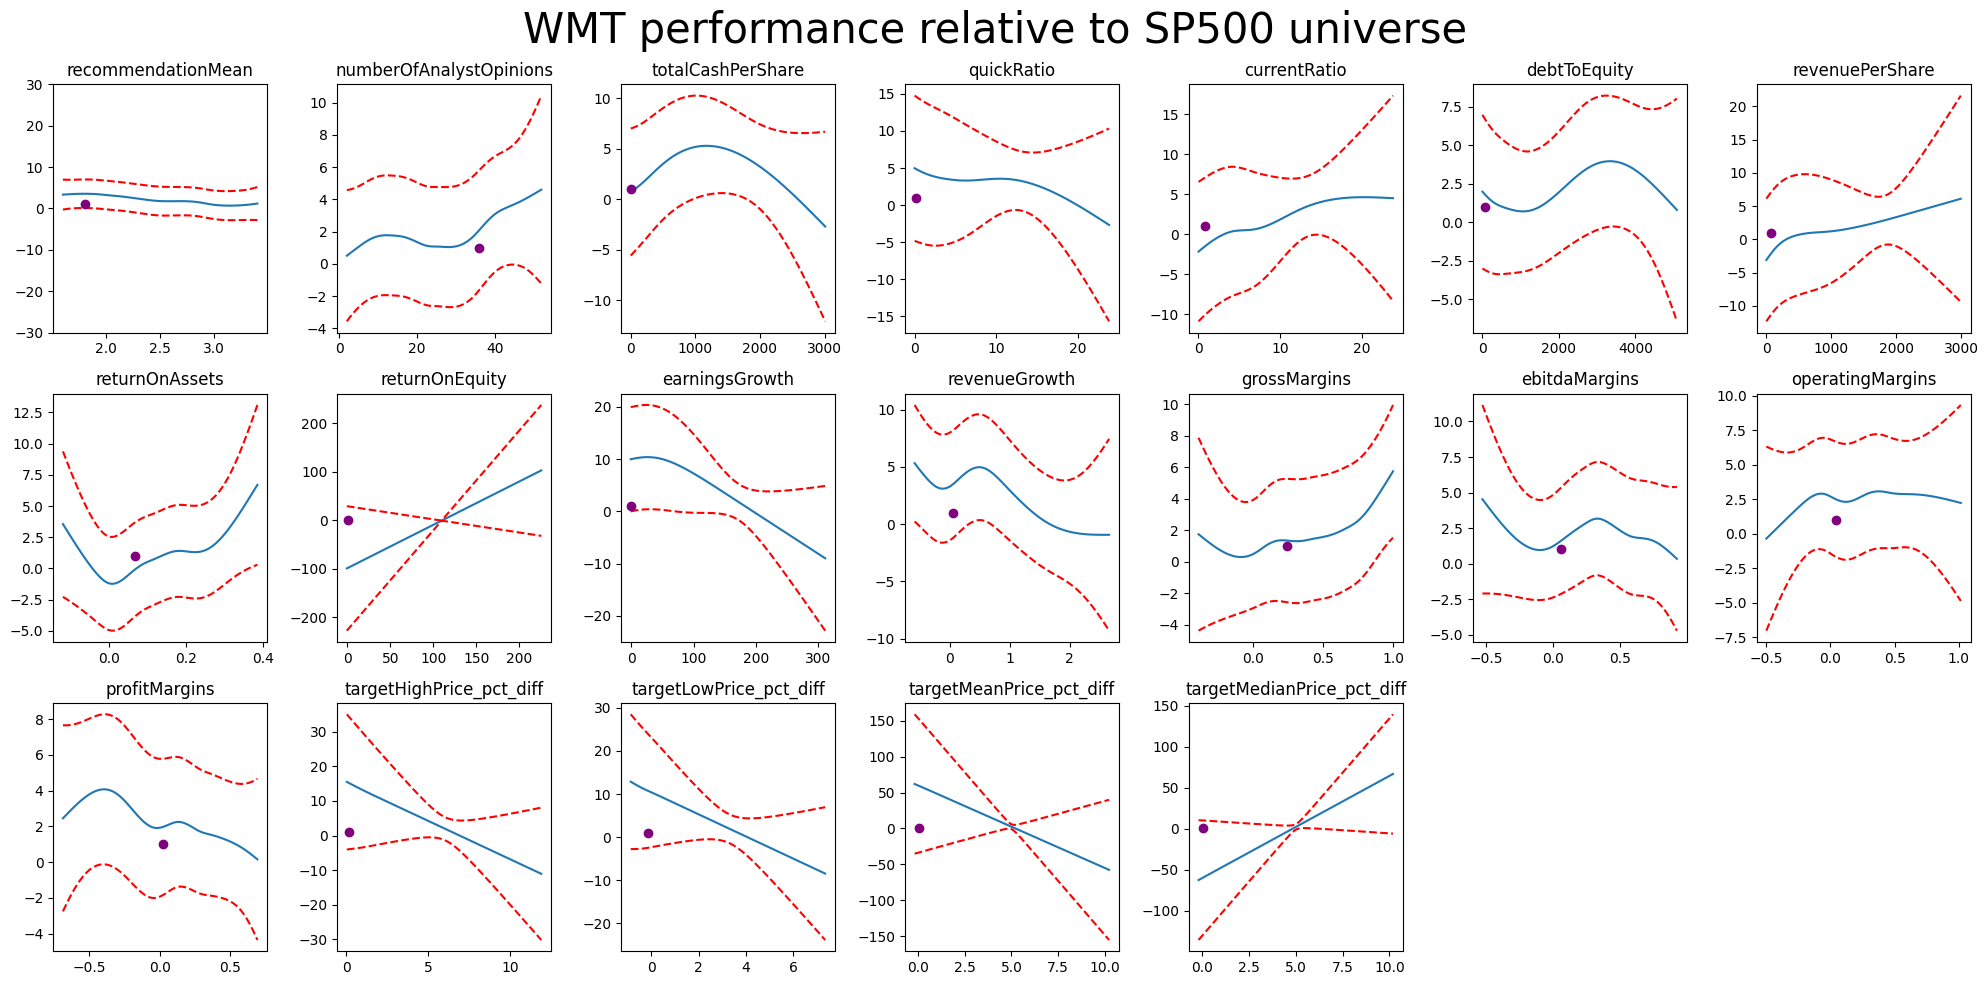

Hold

As a stock analyst reviewing the partial dependence plots and the raw values for this particular stock, my objective is to provide insights into how these factors play a role in the model's prediction that the stock is likely to outperform the S&P 500 over a 10-year period.

First, the recommendation mean of 2.4, as indicated by the purple dot on the recommendationMean graph, falls in a range that shows relatively little impact on the predicted outcome, which seems neutral. The number of analyst opinions is at 23, suggesting a decent amount of coverage, and it corresponds to an area on its graph that slightly favors a positive outlook.

The total cash per share value of 0.951 and quick ratio of 0.429 are somewhat low, indicating the company does not have a high proportion of liquid assets compared to its immediate liabilities. However, the position of the purple dot in the graph suggests this isn't heavily weighing down the prediction. The current ratio of 0.713, which measures t

'Hold'

In [31]:
invest("WMT", client="income")

## AT&T, client=Growth

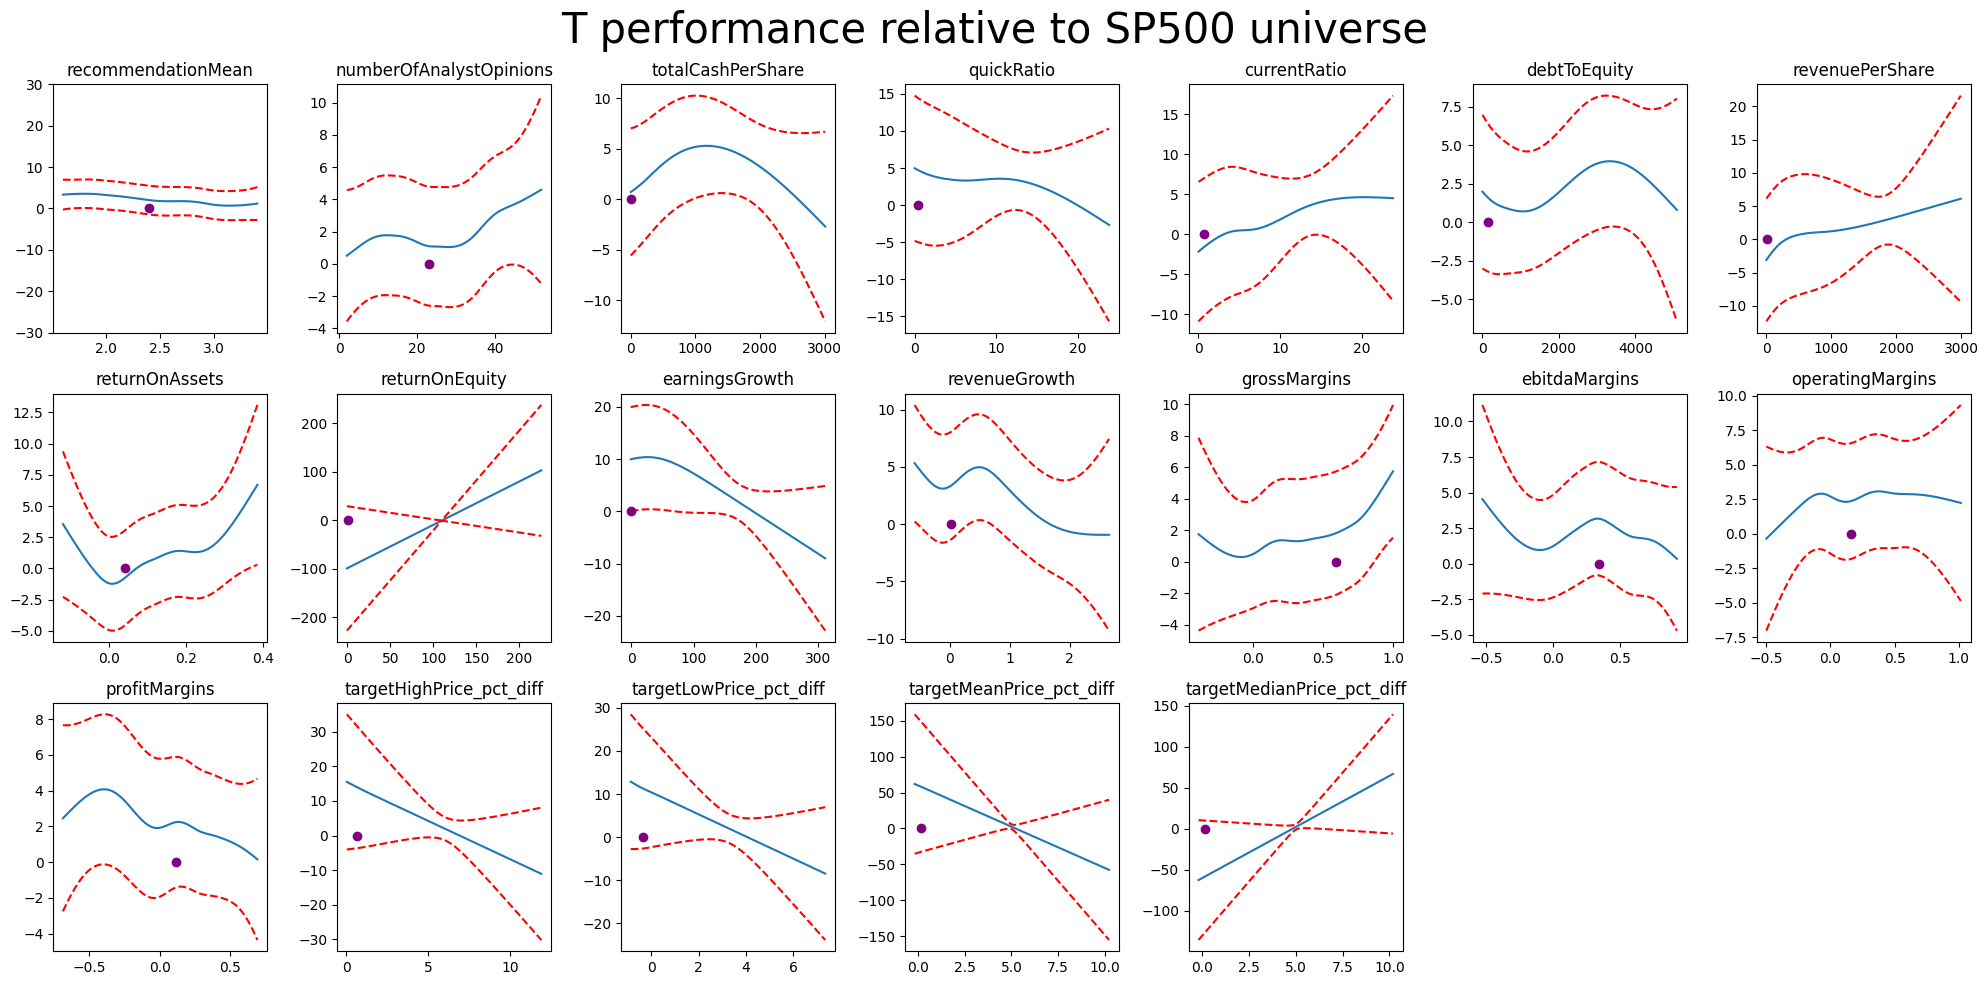

Hold

To provide an analysis of this stock and the model's prediction, we will go through several key metrics as shown in the partial dependence graphs and relate them to the company's values indicated by the purple dots. Remember, these graphs compare the performance of this stock to the S&P 500 universe over a 10-year period. The vertical axis represents the influence on the performance relative to the S&P 500 (positive numbers are better, indicating outperformance, while negative numbers suggest underperformance).

1. **Recommendation Mean (2.4):** The company has a recommendation mean of 2.4, which places it in a region where the relative performance does not seem to be strongly affected according to the graph. This is a neutral to slightly positive indicator.

2. **Number of Analyst Opinions (23.0):** With 23 analyst opinions, the stock is in a zone that slightly favors outperformance. This suggests a reasonable level of confidence or interest from the analyst community, which can

'Hold'

In [34]:
invest("T", client="growth")

## Costco, client=ESG

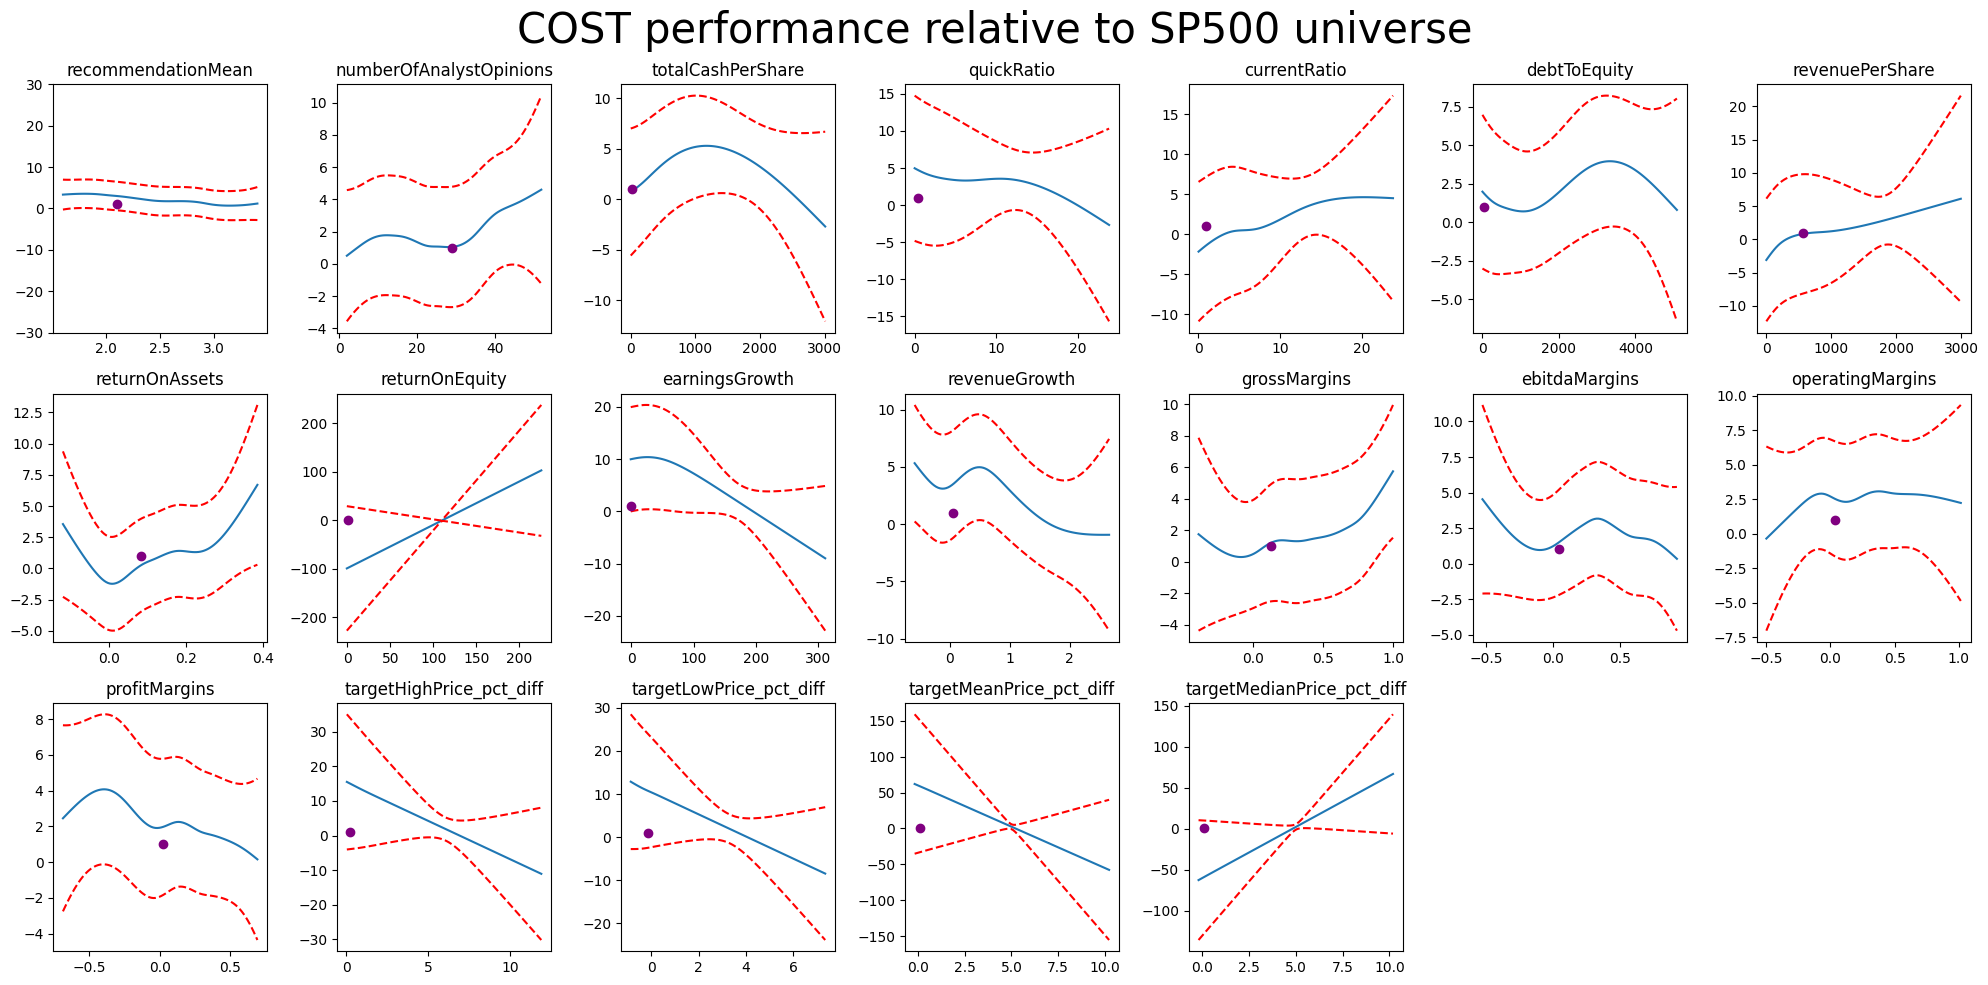

Buy

Based on the partial dependence plots and the company's raw values for different financial metrics, we can dissect why the model predicts that the stock in question has a better 10-year compounded annual growth rate (CAGR) than the S&P 500. 

For non-technical folks, a partial dependence plot helps us understand the relationship between certain company metrics and the model’s prediction—whether these features have a positive or negative influence on a stock's performance relative to a benchmark, in this case, the S&P 500.

1. **Recommendation Mean**: The recommendation mean is 2.4, sitting in a neutral-to-positive impact area of the plot, which suggests that analysts' recommendations are slightly favorable for the stock's performance.

2. **Number of Analyst Opinions**: With 23 opinions, the stock is at a spot on the graph where more analyst attention correlates with better performance, indicating credibility and investor interest.

3. **Total Cash Per Share**: Although having low

'Buy'

In [33]:
invest("COST", client="esg")